In [1]:
from google.colab import drive
drive.mount('/content/drive/')

Mounted at /content/drive/


# Problem 1

데이터 로드 및 전처리

In [69]:
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt
from torch.utils.data import DataLoader, TensorDataset
from sklearn.model_selection import train_test_split

# 데이터 로드 및 전처리
train_data = pd.read_csv('/content/drive/MyDrive/딥러닝응용_금오공대/딥러닝응용 hw5/train.csv')
test_data = pd.read_csv('/content/drive/MyDrive/딥러닝응용_금오공대/딥러닝응용 hw5/test.csv')



In [70]:
# Data Check
train_data.head()


,Date,Open,High,Low,Volume,Close
0,2015-12-16,120,123,118,13181000,123
1,2015-12-17,124,126,122,17284900,123
2,2015-12-18,121,122,118,17948100,118
3,2015-12-21,120,120,116,11670000,117
4,2015-12-22,117,117,115,9689000,116


In [71]:
test_data.head()

,Date,Open,High,Low,Volume
0,2019-10-21,273,280,269,12599200
1,2019-10-22,271,275,266,11802400
2,2019-10-23,268,274,267,7133500
3,2019-10-24,272,274,269,4827400
4,2019-10-25,271,278,270,4747800


In [73]:
from torch.utils.data import DataLoader, Dataset

# 데이터 전처리 클래스 정의
class NetflixData(Dataset):
    def __init__(self, data, seq_length=30):
        self.data = data
        self.seq_length = seq_length
        self.inputs = self.data[['Open', 'High', 'Low', 'Volume']].values / self.data[['Open', 'High', 'Low', 'Volume']].values.max(axis=0)
        self.labels = self.data['Close'].values / self.data['Close'].values.max()

    def __len__(self):
        return len(self.data) - self.seq_length

    def __getitem__(self, idx):
        return (self.inputs[idx:idx+self.seq_length], self.labels[idx+self.seq_length])

# 데이터셋 및 데이터로더 정의
train_dataset = NetflixData(train_data)
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)

모델 구현(RNN, LSTM, GRU)

In [74]:
# 모델 정의
class StockRNN(nn.Module):
    def __init__(self, model_type='RNN', input_size=4, hidden_size=8, num_layers=2, dropout=0.2):
        super(StockRNN, self).__init__()
        if model_type == 'RNN':
            self.rnn = nn.RNN(input_size, hidden_size, num_layers, batch_first=True, dropout=dropout)
        elif model_type == 'LSTM':
            self.rnn = nn.LSTM(input_size, hidden_size, num_layers, batch_first=True, dropout=dropout)
        elif model_type == 'GRU':
            self.rnn = nn.GRU(input_size, hidden_size, num_layers, batch_first=True, dropout=dropout)
        self.fc = nn.Linear(hidden_size * 30, 1)  # seq_length는 30으로 고정
        self.dropout = nn.Dropout(dropout)

    def forward(self, x):
        x, _ = self.rnn(x)
        x = x.reshape(x.size(0), -1)
        x = self.dropout(x)
        x = self.fc(x)
        return x

모델 훈련 및 평가

In [75]:
# 모델 훈련 함수
def train_model(model_type):
    model = StockRNN(model_type=model_type).to(device)
    criterion = nn.MSELoss()
    optimizer = optim.Adam(model.parameters(), lr=0.001)

    # 훈련
    model.train()
    for epoch in range(200):  # 파일의 epoch와 동일하게 200으로 설정
        total_loss = 0
        for inputs, labels in train_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            optimizer.zero_grad()
            outputs = model(inputs.float())
            loss = criterion(outputs, labels.unsqueeze(1).float())
            loss.backward()
            optimizer.step()
            total_loss += loss.item()
        print(f'{model_type} Epoch {epoch+1}, Loss: {total_loss / len(train_loader)}')

    torch.save(model.state_dict(), f"./{model_type.lower()}_model.pth")
    return model


In [76]:
# 모델 평가 및 예측 함수
def predict(model, dataset):
    model.eval()
    predictions = []
    loader = DataLoader(dataset, batch_size=1, shuffle=False)
    with torch.no_grad():
        for inputs, _ in loader:
            inputs = inputs.to(device)
            outputs = model(inputs.float())
            predictions.append(outputs.cpu().numpy().flatten()[0])
    return predictions

# 디바이스 설정
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [77]:
# 모델 훈련 및 평가
results = {}
for model_type in ['RNN', 'LSTM', 'GRU']:
    print(f'Training and evaluating {model_type}')
    trained_model = train_model(model_type)
    train_predictions = predict(trained_model, train_dataset)
    results[model_type] = {'train': train_predictions}

# 실제 값과 예측 값 비교 (훈련 데이터 사용)
actual = train_data['Close'].values / train_data['Close'].values.max()
actual = actual[30:]  # seq_length 이후의 값만 사용


Training and evaluating RNN
RNN Epoch 1, Loss: 0.08546095279355843
RNN Epoch 2, Loss: 0.03525647446513176
RNN Epoch 3, Loss: 0.0170844452145199
RNN Epoch 4, Loss: 0.013894001518686612
RNN Epoch 5, Loss: 0.01352460840716958
RNN Epoch 6, Loss: 0.01184501323538522
RNN Epoch 7, Loss: 0.00959380897693336
RNN Epoch 8, Loss: 0.008668758270020286
RNN Epoch 9, Loss: 0.008116204757243395
RNN Epoch 10, Loss: 0.006873109377920628
RNN Epoch 11, Loss: 0.0065254537078241505
RNN Epoch 12, Loss: 0.006108946120366454
RNN Epoch 13, Loss: 0.0058068525201330585
RNN Epoch 14, Loss: 0.004993248335085809
RNN Epoch 15, Loss: 0.005299327437145015
RNN Epoch 16, Loss: 0.004804564647686979
RNN Epoch 17, Loss: 0.004632502786504725
RNN Epoch 18, Loss: 0.004405218060128391
RNN Epoch 19, Loss: 0.0040021654839317005
RNN Epoch 20, Loss: 0.0041372236795723435
RNN Epoch 21, Loss: 0.0040082218125462536
RNN Epoch 22, Loss: 0.004269724028805892
RNN Epoch 23, Loss: 0.003940489375963807
RNN Epoch 24, Loss: 0.003432971394310395

In [78]:
# 성능 평가
performance = {}
for model_type in ['RNN', 'LSTM', 'GRU']:
    if len(results[model_type]['train']) > 0:  # 예측 결과가 비어있지 않은지 확인
        mse = mean_squared_error(actual[:len(results[model_type]['train'])], results[model_type]['train'])
        mae = mean_absolute_error(actual[:len(results[model_type]['train'])], results[model_type]['train'])
        rmse = np.sqrt(mse)
        performance[model_type] = {'MSE': mse, 'MAE': mae, 'RMSE': rmse}

print('Performance:', performance)



Performance: {'RNN': {'MSE': 0.0006141865768003263, 'MAE': 0.01757426759168706, 'RMSE': 0.024782787914202194}, 'LSTM': {'MSE': 0.000635163706097929, 'MAE': 0.01866934764740723, 'RMSE': 0.025202454366547895}, 'GRU': {'MSE': 0.0006834728215481423, 'MAE': 0.02002897498478152, 'RMSE': 0.026143313132580236}}


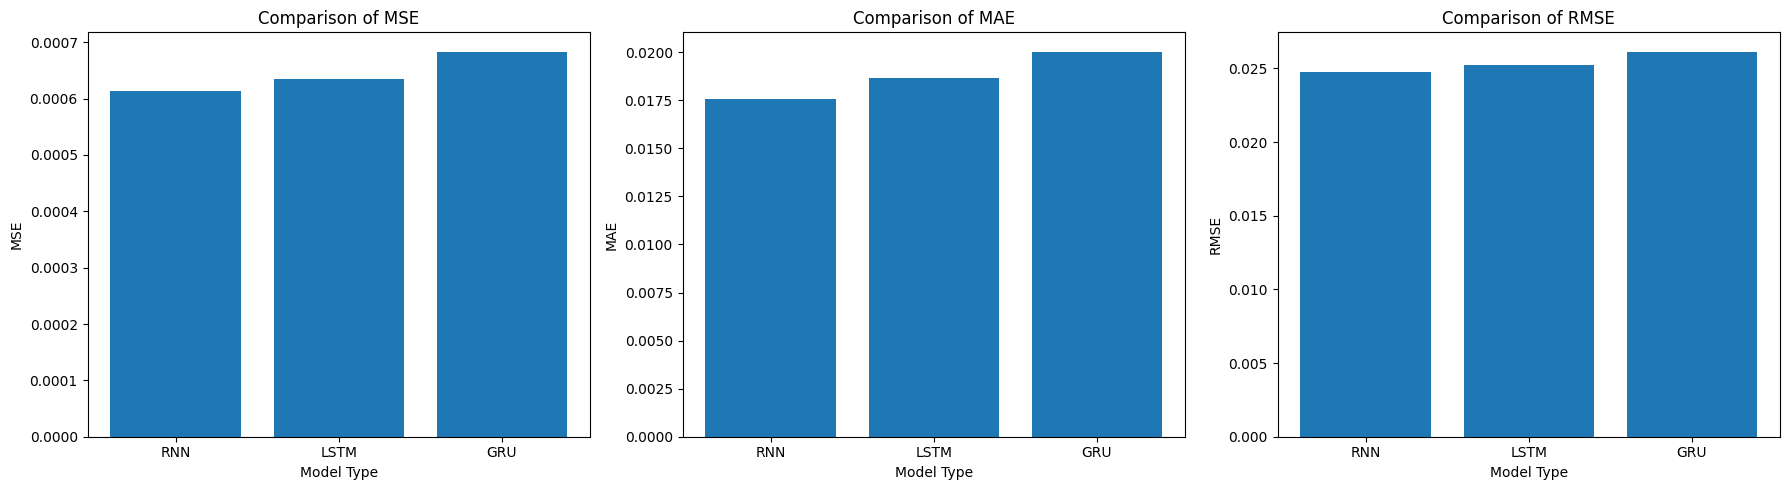

In [80]:
# 성능 평가 결과 시각화
metrics = ['MSE', 'MAE', 'RMSE']
model_types = ['RNN', 'LSTM', 'GRU']
performance_values = {metric: [performance[model_type][metric] for model_type in model_types] for metric in metrics}

fig, axs = plt.subplots(1, 3, figsize=(18, 5))

for idx, metric in enumerate(metrics):
    axs[idx].bar(model_types, performance_values[metric])
    axs[idx].set_title(f'Comparison of {metric}')
    axs[idx].set_xlabel('Model Type')
    axs[idx].set_ylabel(metric)

plt.tight_layout()
plt.show()

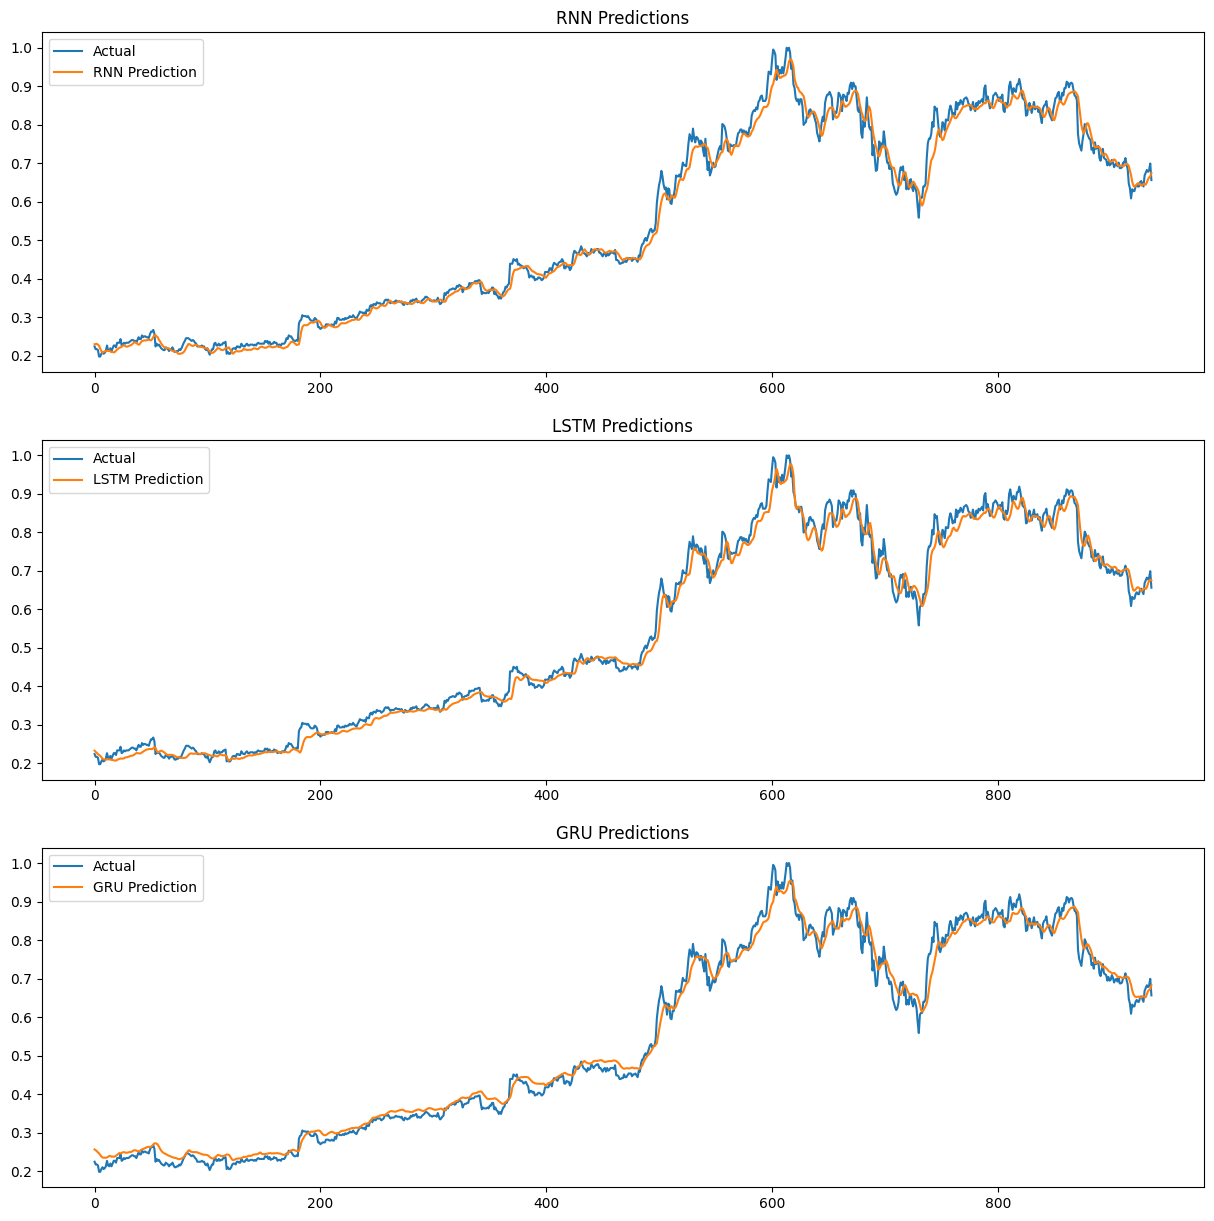

In [79]:
# 결과 시각화
fig, axs = plt.subplots(3, 1, figsize=(15, 15))

for idx, model_type in enumerate(['RNN', 'LSTM', 'GRU']):
    axs[idx].plot(actual[:len(results[model_type]['train'])], label='Actual')
    if len(results[model_type]['train']) > 0:
        axs[idx].plot(results[model_type]['train'], label=f'{model_type} Prediction')
    axs[idx].legend()
    axs[idx].set_title(f'{model_type} Predictions')

plt.show()

# Problem 2

감정분석: IMDb 데이터 - 긍정 or 부정

데이터 전처

In [81]:
import numpy as np
import pandas as pd
from keras.datasets import imdb
from keras.preprocessing.sequence import pad_sequences
from sklearn.model_selection import train_test_split

# IMDb 데이터셋 로드
max_features = 10000  # 사용할 단어 수
maxlen = 200  # 시퀀스 길이

(X_train, y_train), (X_test, y_test) = imdb.load_data(num_words=max_features)

# 패딩
X_train = pad_sequences(X_train, maxlen=maxlen)
X_test = pad_sequences(X_test, maxlen=maxlen)

# 데이터셋 분할 (훈련/검증)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.2, random_state=42)


17464789/17464789 [==============================] - 2s 0us/step


In [82]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset

# 데이터 로더 정의
batch_size = 32
train_loader = DataLoader(TensorDataset(torch.tensor(X_train, dtype=torch.long), torch.tensor(y_train, dtype=torch.long)), batch_size=batch_size, shuffle=True)
val_loader = DataLoader(TensorDataset(torch.tensor(X_val, dtype=torch.long), torch.tensor(y_val, dtype=torch.long)), batch_size=batch_size, shuffle=False)
test_loader = DataLoader(TensorDataset(torch.tensor(X_test, dtype=torch.long), torch.tensor(y_test, dtype=torch.long)), batch_size=batch_size, shuffle=False)



모델 정의 및 훈련

In [83]:
# 모델 정의
class SentimentRNN(nn.Module):
    def __init__(self, model_type='RNN', input_size=10000, embed_size=128, hidden_size=128, num_layers=2, num_classes=2, dropout=0.2):
        super(SentimentRNN, self).__init__()
        self.embedding = nn.Embedding(input_size, embed_size)
        if model_type == 'RNN':
            self.rnn = nn.RNN(embed_size, hidden_size, num_layers, batch_first=True, dropout=dropout)
        elif model_type == 'LSTM':
            self.rnn = nn.LSTM(embed_size, hidden_size, num_layers, batch_first=True, dropout=dropout)
        elif model_type == 'GRU':
            self.rnn = nn.GRU(embed_size, hidden_size, num_layers, batch_first=True, dropout=dropout)
        self.fc = nn.Linear(hidden_size, num_classes)
        self.dropout = nn.Dropout(dropout)

    def forward(self, x):
        x = self.embedding(x)
        x, _ = self.rnn(x)
        x = x[:, -1, :]  # 마지막 타임스텝의 은닉 상태
        x = self.dropout(x)
        x = self.fc(x)
        return x


In [86]:

# 모델 훈련 함수
def train_model(model_type):
    model = SentimentRNN(model_type=model_type).to(device)
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=0.001)

    # 훈련
    model.train()
    for epoch in range(50):
        total_loss = 0
        for inputs, labels in train_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            total_loss += loss.item()
        print(f'{model_type} Epoch {epoch+1}, Loss: {total_loss / len(train_loader)}')

    return model



모델 평가

In [87]:

# 모델 평가 함수
def evaluate_model(model, loader):
    model.eval()
    correct, total = 0, 0
    with torch.no_grad():
        for inputs, labels in loader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            _, predicted = torch.max(outputs, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
    return correct / total

# 디바이스 설정
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# 모델 훈련 및 평가
results = {}
for model_type in ['RNN', 'LSTM', 'GRU']:
    print(f'Training and evaluating {model_type}')
    trained_model = train_model(model_type)
    train_acc = evaluate_model(trained_model, train_loader)
    val_acc = evaluate_model(trained_model, val_loader)
    test_acc = evaluate_model(trained_model, test_loader)
    results[model_type] = {'train_acc': train_acc, 'val_acc': val_acc, 'test_acc': test_acc}
    print(f'{model_type} Train Accuracy: {train_acc:.4f}, Validation Accuracy: {val_acc:.4f}, Test Accuracy: {test_acc:.4f}')

print('Results:', results)

Training and evaluating RNN
RNN Epoch 1, Loss: 0.6569014249801636
RNN Epoch 2, Loss: 0.632490539932251
RNN Epoch 3, Loss: 0.5516917370319366
RNN Epoch 4, Loss: 0.5115229188442231
RNN Epoch 5, Loss: 0.5469217044115067
RNN Epoch 6, Loss: 0.549684228515625
RNN Epoch 7, Loss: 0.48171392776966093
RNN Epoch 8, Loss: 0.5055754227161408
RNN Epoch 9, Loss: 0.41411122744083406
RNN Epoch 10, Loss: 0.3885865010976791
RNN Epoch 11, Loss: 0.3602268085479736
RNN Epoch 12, Loss: 0.432011999630928
RNN Epoch 13, Loss: 0.35456740440130236
RNN Epoch 14, Loss: 0.3124688690960407
RNN Epoch 15, Loss: 0.2733928864002228
RNN Epoch 16, Loss: 0.2657866092681885
RNN Epoch 17, Loss: 0.2689779732465744
RNN Epoch 18, Loss: 0.2524731926977634
RNN Epoch 19, Loss: 0.24789977054595946
RNN Epoch 20, Loss: 0.23872216745615005
RNN Epoch 21, Loss: 0.17660830818414688
RNN Epoch 22, Loss: 0.1538044160529971
RNN Epoch 23, Loss: 0.18468046899437904
RNN Epoch 24, Loss: 0.26889152849316594
RNN Epoch 25, Loss: 0.1749717883259058
R

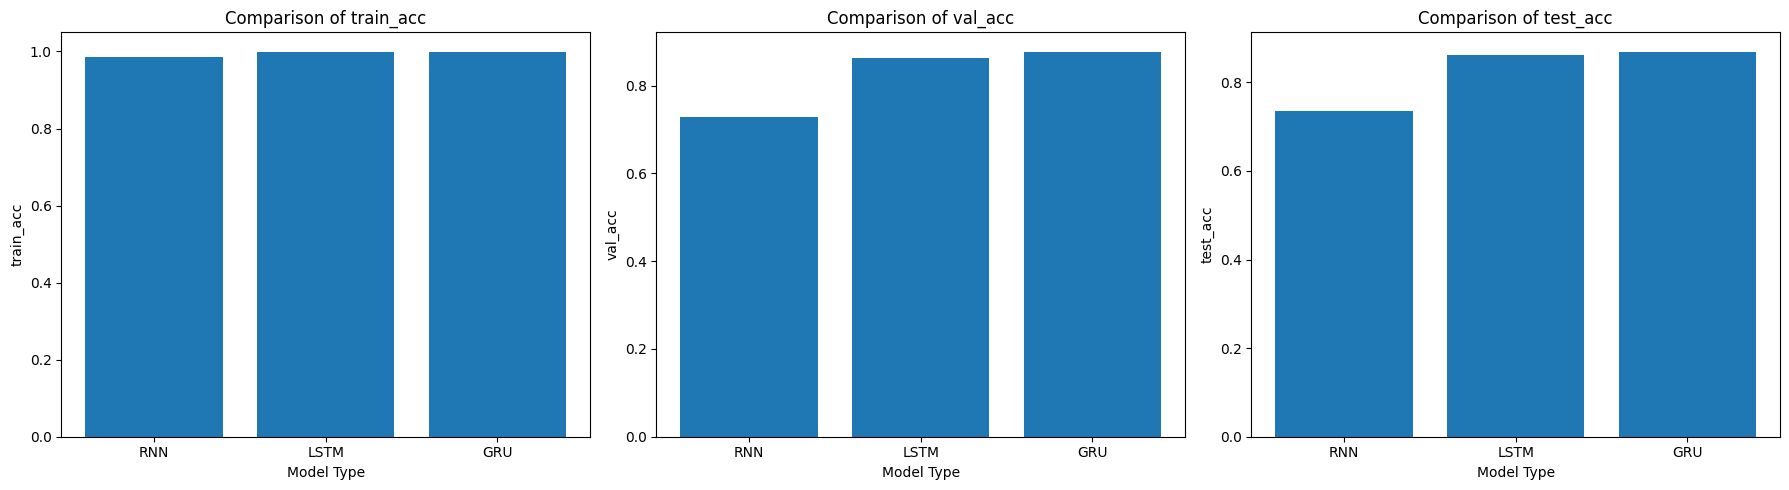

In [88]:
import matplotlib.pyplot as plt

metrics = ['train_acc', 'val_acc', 'test_acc']
model_types = ['RNN', 'LSTM', 'GRU']
performance_values = {metric: [results[model_type][metric] for model_type in model_types] for metric in metrics}

fig, axs = plt.subplots(1, 3, figsize=(18, 5))

for idx, metric in enumerate(metrics):
    axs[idx].bar(model_types, performance_values[metric])
    axs[idx].set_title(f'Comparison of {metric}')
    axs[idx].set_xlabel('Model Type')
    axs[idx].set_ylabel(metric)

plt.tight_layout()
plt.show()
